In [1]:
import numpy as np
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class Batch:
    quality = 0.5
    alpha = 1
    beta = 1
    def __init__(self, quality):
        self.quality = quality
        
    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)
    
    def get_element(self):
        good = np.random.rand() < self.quality
        self.alpha= self.alpha+ int(good)
        self.beta= self.beta+ 1 -int(good)
        return good
    
    def __repr__(self):
        return f"<a:{self.alpha} b:{self.beta} q: {self.quality}>"

In [3]:
import scipy.stats as st

class Factory:
    batches = []
    systems = 0
    good = 0
    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0
    def get_element(self):
        samples = [batch.sample_distribution() for batch in self.batches]
        choice = np.argmax(samples)
        result = self.batches[choice].get_element()
        self.systems = self.systems + 1
        self.good = self.good + int(result)
        best_choice = np.argmax([batch.quality for batch in self.batches])
        return int(choice != best_choice), abs(self.batches[choice].quality - self.batches[best_choice].quality)
        
def plot_batches(factory, colors):
    x = np.linspace(0, 1, 1000)
    for b, color in zip(factory.batches, colors):
        plt.plot(x, st.beta.pdf(x, b.alpha, b.beta), label=fr'q={b.quality} $\alpha={b.alpha}  \beta={b.beta}$', color=color)
        plt.vlines(b.quality, 0, st.beta.pdf(b.quality, b.alpha, b.beta), linestyles='dashed', color=color)
    plt.legend()
    plt.show()

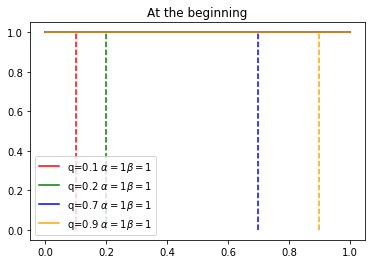

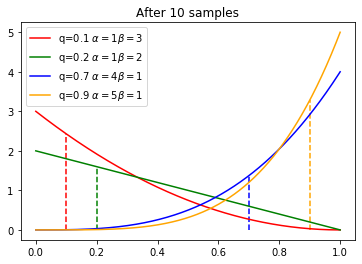

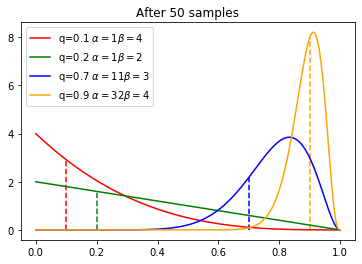

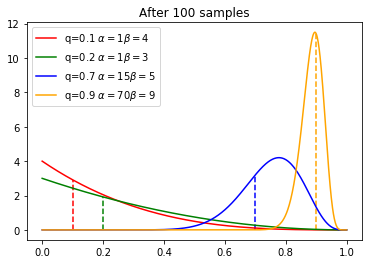

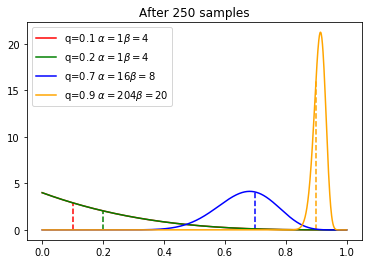

In [4]:
factory = Factory()
factory.set_batches([0.1, 0.2, 0.7, 0.9])
plt.title("At the beginning")
colors = ['red', 'green', 'blue', 'orange']
plot_batches(factory, colors)

steps = [10, 40, 50, 150]

for j, s in enumerate(steps):
    for i in range(s):
        factory.get_element()
    plt.title(f"After {np.sum(steps[:j+1])} samples")
    plot_batches(factory, colors)



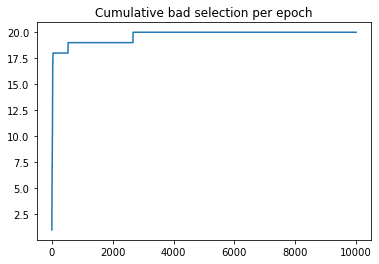

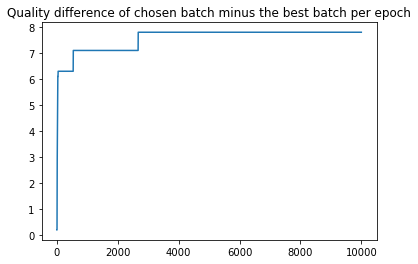

In [5]:
factory = Factory()
factory.set_batches([0.1, 0.2, 0.7, 0.9])
bad_batch_choices = []
quality_diffs = []
for i in range(10000):
    bad_choice, quality_diff = factory.get_element()
    bad_batch_choices.append(bad_choice)
    quality_diffs.append(quality_diff)
bad_batch_choices = np.cumsum(bad_batch_choices)
quality_diffs = np.cumsum(quality_diffs)
plt.title("Cumulative bad selection per epoch")
plt.plot(bad_batch_choices)
plt.show()
plt.title("Quality difference of chosen batch minus the best batch per epoch")
plt.plot(quality_diffs)

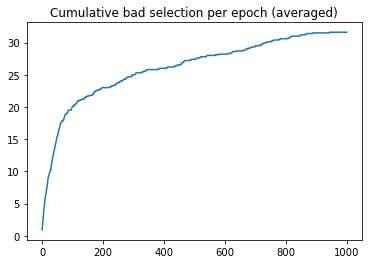

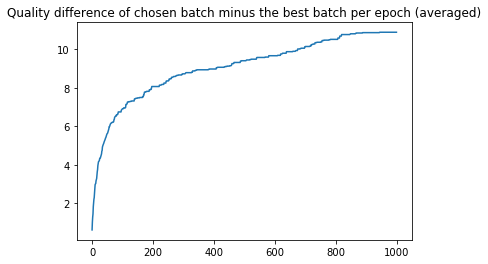

In [6]:
bad_batch_choices_acc = []
quality_diffs_acc = []
for runs in range(10):
    factory = Factory()
    factory.set_batches([0.1, 0.2, 0.7, 0.9])
    bad_batch_choices = []
    quality_diffs = []
    for i in range(1000):
        bad_choice, quality_diff = factory.get_element()
        bad_batch_choices.append(bad_choice)
        quality_diffs.append(quality_diff)
    quality_diffs = np.cumsum(quality_diffs)
    bad_batch_choices = np.cumsum(bad_batch_choices)
    bad_batch_choices_acc.append(bad_batch_choices)
    quality_diffs_acc.append(quality_diffs)

mean_bad_batch = np.mean(bad_batch_choices_acc, axis=0)
plt.title("Cumulative bad selection per epoch (averaged)")
plt.plot(mean_bad_batch)
plt.show()
mean_quality_diff = np.mean(quality_diffs_acc, axis=0)
plt.title("Quality difference of chosen batch minus the best batch per epoch (averaged)")
plt.plot(mean_quality_diff)

In [7]:
class FactoryRotate:
    batches = []
    systems = 0
    good = 0
    
    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0
        self.current_batch_index = 0
        
    def get_element(self):
        choice = self.current_batch_index
        result = self.batches[choice].get_element()
        if not result:
            self.current_batch_index += 1
            if self.current_batch_index == len(self.batches):
                self.current_batch_index = 0
        self.systems = self.systems + 1
        self.good = self.good + int(result)
        best_choice = np.argmax([batch.quality for batch in self.batches])
        return int(choice != best_choice), abs(self.batches[choice].quality - self.batches[best_choice].quality)

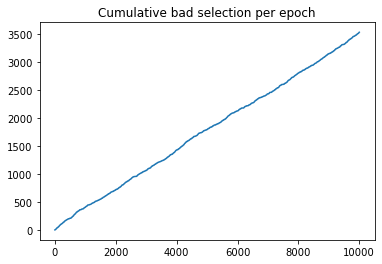

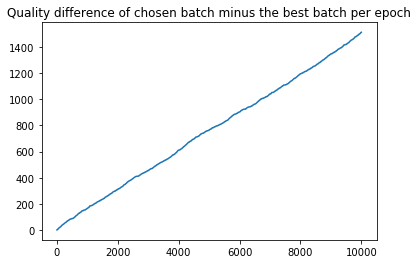

In [10]:
factory = FactoryRotate()
factory.set_batches([0.1, 0.2, 0.7, 0.9])
bad_batch_choices = []
quality_diffs = []
for i in range(10000):
    bad_choice, quality_diff = factory.get_element()
    bad_batch_choices.append(bad_choice)
    quality_diffs.append(quality_diff)
bad_batch_choices = np.cumsum(bad_batch_choices)
quality_diffs = np.cumsum(quality_diffs)
plt.title("Cumulative bad selection per epoch")
plt.plot(bad_batch_choices)
plt.show()
plt.title("Quality difference of chosen batch minus the best batch per epoch")
plt.plot(quality_diffs)


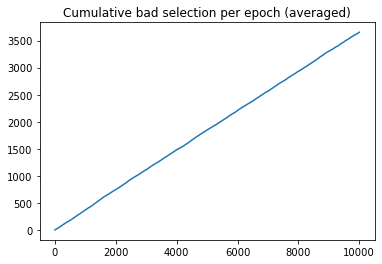

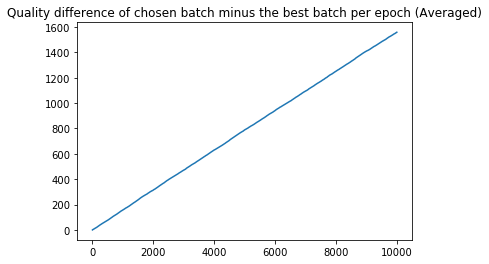

In [11]:
bad_batch_choices_acc = []
quality_diffs_acc = []
for runs in range(10):
    factory = FactoryRotate()
    factory.set_batches([0.1, 0.2, 0.7, 0.9])
    bad_batch_choices = []
    quality_diffs = []
    for i in range(10000):
        bad_choice, quality_diff = factory.get_element()
        bad_batch_choices.append(bad_choice)
        quality_diffs.append(quality_diff)
    quality_diffs = np.cumsum(quality_diffs)
    bad_batch_choices = np.cumsum(bad_batch_choices)
    bad_batch_choices_acc.append(bad_batch_choices)
    quality_diffs_acc.append(quality_diffs)

mean_bad_batch = np.mean(bad_batch_choices_acc, axis=0)
plt.title("Cumulative bad selection per epoch (averaged)")
plt.plot(mean_bad_batch)
plt.show()
plt.title("Quality difference of chosen batch minus the best batch per epoch (Averaged)")
mean_quality_diff = np.mean(quality_diffs_acc, axis=0)
plt.plot(mean_quality_diff)

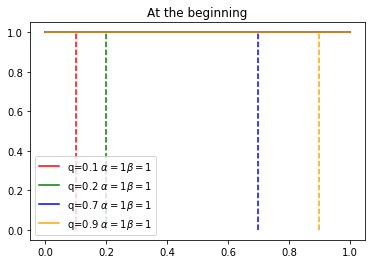

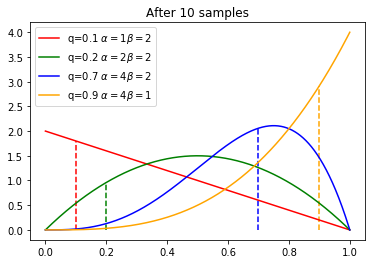

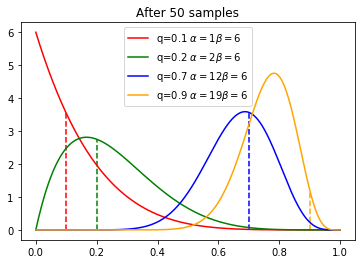

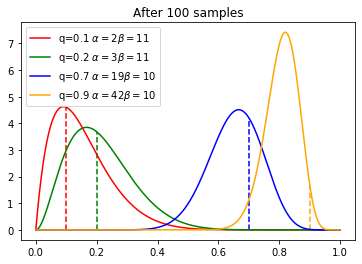

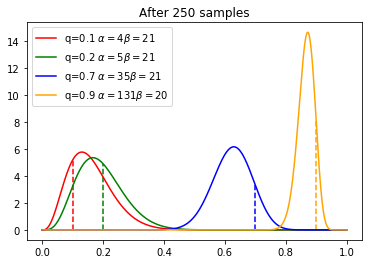

In [12]:
factory = FactoryRotate()
factory.set_batches([0.1, 0.2, 0.7, 0.9])
plt.title("At the beginning")
colors = ['red', 'green', 'blue', 'orange']
plot_batches(factory, colors)

steps = [10, 40, 50, 150]

for j, s in enumerate(steps):
    for i in range(s):
        factory.get_element()
    plt.title(f"After {np.sum(steps[:j+1])} samples")
    plot_batches(factory, colors)

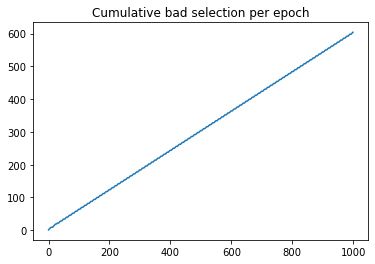

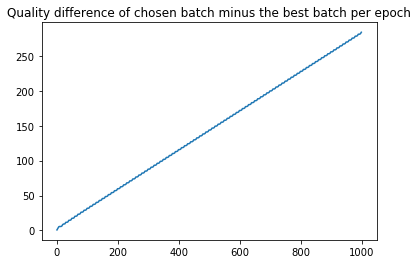

In [28]:
class QualityControlledBatch:
    quality = 0.5
    alpha = 1
    beta = 1
    def __init__(self, quality):
        self.quality = quality
        self.total = 0
        self.good = 0
        
    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)
    
    def get_element(self):
        is_good = np.random.rand() < self.quality
        self.alpha= self.alpha+ int(is_good)
        self.beta= self.beta+ 1 -int(is_good)
        if is_good:
            self.good += 1
        self.total += 1
        return is_good
    
    def success_ratio(self):
        if self.total == 0:
            return 0
        return self.good / self.total
    
    def __repr__(self):
        return f"<a:{self.alpha} b:{self.beta} q: {self.quality}>"

qualities = [0.1, 0.2, 0.7, 0.9]
batches = [QualityControlledBatch(quality) for quality in qualities]


def ranked_strategy(batches, iters):
    bad_batch_choices = []
    quality_diffs = []
    counter = 0
    while True:
        sorted_batches = sorted(batches, key=lambda b: b.success_ratio(), reverse = True)
        n = len(sorted_batches)
        for i, b in enumerate(sorted_batches):
            for j in range(n - i):
                res = b.get_element()
                bad_choice = int(b.quality != max([batch.quality for batch in batches]))
                quality_diff = abs(b.quality - max([batch.quality for batch in batches]))
                bad_batch_choices.append(bad_choice)
                quality_diffs.append(quality_diff)
                counter += 1
                if counter == iters:
                    bad_batch_choices = np.cumsum(bad_batch_choices)
                    quality_diffs = np.cumsum(quality_diffs)
                    return bad_batch_choices, quality_diffs

                
bad_batch_choices, quality_diffs = ranked_strategy(batches, 1000)
plt.title("Cumulative bad selection per epoch")
plt.plot(bad_batch_choices)
plt.show()
plt.title("Quality difference of chosen batch minus the best batch per epoch")
plt.plot(quality_diffs)
plt.show()

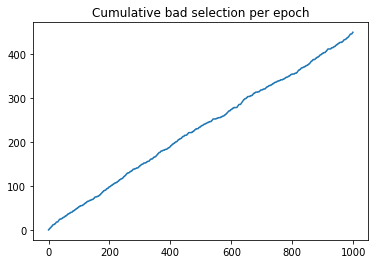

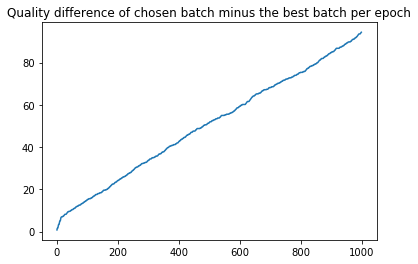

In [34]:

qualities = [0.1, 0.2, 0.7, 0.9]
batches = [QualityControlledBatch(quality) for quality in qualities]


def roulette_wheel_strategy(batches, iters):
    bad_batch_choices = []
    quality_diffs = []
    seed_counter = 0
    j = 0
    for i in range(iters):
        if seed_counter < 15:
            index = j
            b = batches[index]
            j += 1
            if j == len(batches):
                j = 0           
            seed_counter += 1
        else:
            p = np.array([b.success_ratio() for b in batches])
            if(np.all(p==0)):
                p = np.ones_like(p)
            p = p/p.sum(axis=0)

            index = np.random.choice(list(range(len(batches))), p = p)
            b = batches[index]
        #print([b.success_ratio() for b in batches])
        res = b.get_element()
        bad_choice = int(b.quality != max([batch.quality for batch in batches]))
        quality_diff = abs(b.quality - max([batch.quality for batch in batches]))
        bad_batch_choices.append(bad_choice)
        quality_diffs.append(quality_diff)

    bad_batch_choices = np.cumsum(bad_batch_choices)
    quality_diffs = np.cumsum(quality_diffs)
    return bad_batch_choices, quality_diffs



bad_batch_choices, quality_diffs = roulette_wheel_strategy(batches, 1000)
#print(bad_batch_choices)
plt.title("Cumulative bad selection per epoch")
plt.plot(bad_batch_choices)
plt.show()
plt.title("Quality difference of chosen batch minus the best batch per epoch")
plt.plot(quality_diffs)
plt.show()

# IMPERFECT MEMORY

In [16]:
import scipy.stats as st
import collections

class ImperfectBatch:
    quality = 0.5
    alpha = 1
    beta = 1
    def __init__(self, quality, memory):
        self.quality = quality
        self.memory = collections.deque(maxlen=memory)
        
    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)
    
    def get_element(self):
        good = np.random.rand() < self.quality
        self.memory.append(int(good))
        self._apply_memory()
        return good
    
    def _apply_memory(self):
        good = self.memory.count(1)
        bad = self.memory.count(0)
        self.alpha = 1 + good
        self.beta = 1 + bad
        
    def __repr__(self):
        return f"<a:{self.alpha} b:{self.beta} q: {self.quality}>"

    
class ImperfectMemoryFactory:
    batches = []
    systems = 0
    good = 0
    def set_batches(self, qualities, memory):
        self.batches = [ImperfectBatch(quality, memory) for quality in qualities]
        self.systems = 0
        self.good = 0
    def get_element(self):
        samples = [batch.sample_distribution() for batch in self.batches]
        choice = np.argmax(samples)
        result = self.batches[choice].get_element()
        self.systems = self.systems + 1
        self.good = self.good + int(result)
        best_choice = np.argmax([batch.quality for batch in self.batches])
        return int(choice != best_choice), abs(self.batches[choice].quality - self.batches[best_choice].quality)

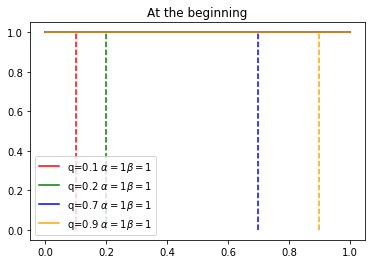

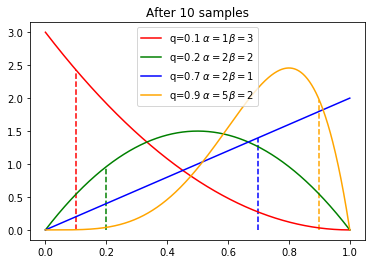

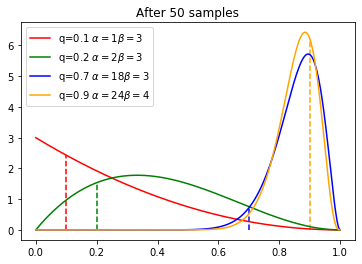

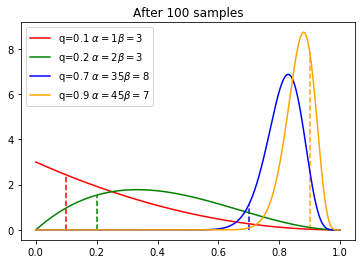

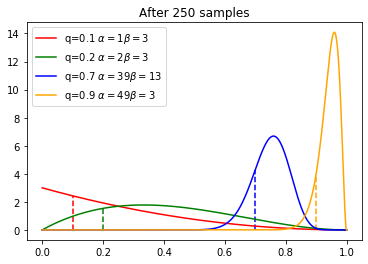

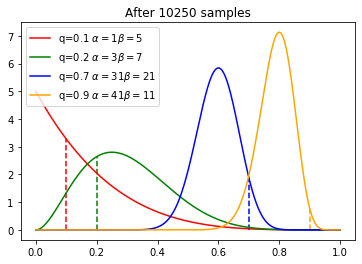

In [17]:
factory = ImperfectMemoryFactory()
factory.set_batches([0.1, 0.2, 0.7, 0.9], 50)
plt.title("At the beginning")
colors = ['red', 'green', 'blue', 'orange']
plot_batches(factory, colors)

steps = [10, 40, 50, 150, 10000]

for j, s in enumerate(steps):
    for i in range(s):
        factory.get_element()
    plt.title(f"After {np.sum(steps[:j+1])} samples")
    plot_batches(factory, colors)



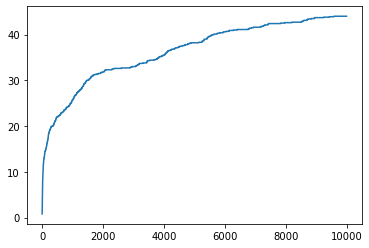

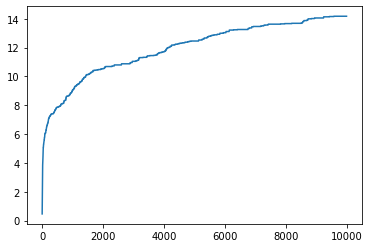

In [18]:
bad_batch_choices_acc = []
quality_diffs_acc = []
for runs in range(10):
    factory = ImperfectMemoryFactory()
    factory.set_batches([0.1, 0.2, 0.7, 0.9], 1000)
    bad_batch_choices = []
    quality_diffs = []
    for i in range(10000):
        bad_choice, quality_diff = factory.get_element()
        bad_batch_choices.append(bad_choice)
        quality_diffs.append(quality_diff)
    quality_diffs = np.cumsum(quality_diffs)
    bad_batch_choices = np.cumsum(bad_batch_choices)
    bad_batch_choices_acc.append(bad_batch_choices)
    quality_diffs_acc.append(quality_diffs)

mean_bad_batch = np.mean(bad_batch_choices_acc, axis=0)
plt.plot(mean_bad_batch)
plt.show()
mean_quality_diff = np.mean(quality_diffs_acc, axis=0)
plt.plot(mean_quality_diff)

## Conclusions

We tested different strategies to selecting the best batch. 
The bayesian method yielded best results - after stabilising in the first few tries the methdod tended to choose the best batch, however sometimes still tried random other branches. as the iterations increased, it tended to choose the best branch more


Imperfect memory was also implemented to this branch, which yielded "worse" but more realistic results. The algorithm only remembers the recent 50 tries, removing its conception about the previous tries. Still, the converging effect can be observed.

Other strategies from the slides were implemented. The first strategy - choose a next branch when you hit a "lemon" performed pretty poorly. It had no regard for any distributions and was esentially equal to a random walk.

The second strategy was much better, though still worse than bayesian. It relied on calculating the percieved success rate of a branch and then taking most samples from the percieved "best".  Still, it accumulated 600 errors over 1000 samples, which is far from the bayesian method

Third strategy was implemented by me. It relies similarly on the percieved quality of the branch. First, it "seeds" the algorithm, taking an element from each sample till N samples are taken (10). Then, having "seeded" the qualities, it proceeds to the roulette selection. Each branch is given a probability of being chosen dependent on how high its percieved quality is. The results are similar, maybe slightly better than strategy 2, but also a bit more random.
